In [1]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila
!pip install fastbook

import fastbook
fastbook.setup_book()
from fastbook import *

from pathlib import Path
from fastai.vision.widgets import *

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
  Using cached https://files.pythonhosted.org/packages/79/6c/05a569e9f703d18aacb89b7ad6075b404e8a4afde2c26b73ca77bb644b14/nbconvert-5.6.1-py2.py3-none-any.whl
ERROR: voila 0.2.10 has requirement nbconvert<7,>=6.0.0, but you'll have nbconvert 5.6.1 which is incompatible.
ERROR: jupyter-server 1.9.0 has requirement tornado>=6.1.0, but you'll have tornado 5.1.1 which is incompatible.
  Found existing installation: nbconvert 6.1.0
    Uninstalling nbconvert-6.1.0:
      Successfully uninstalled nbconvert-6.1.0


In [2]:
path = Path("/content/gdrive/My Drive/Colab Notebooks/flowers").resolve()
path.exists()

True

In [3]:
fns = get_image_files(path)
fns

(#8645) [Path('/content/gdrive/My Drive/Colab Notebooks/flowers/flowers/rose/14810868100_87eb739f26_m.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/flowers/flowers/rose/16484100863_979beacb08.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/flowers/flowers/rose/459042023_6273adc312_n.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/flowers/flowers/rose/16078501836_3ac067e18a.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/flowers/flowers/rose/15184419268_7230e9728e.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/flowers/flowers/rose/3253243865_435c1f2c2b_m.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/flowers/flowers/rose/2122401867_cd86c5f114_n.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/flowers/flowers/rose/2093263381_afd51358a3.jpg'),Path('/content/gdrive/My Drive/Colab Notebooks/flowers/flowers/rose/15060816740_68e1b2c31b.jpg')...]

In [4]:
db = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128,min_scale=0.3),
    batch_tfms=aug_transforms()
)
db

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


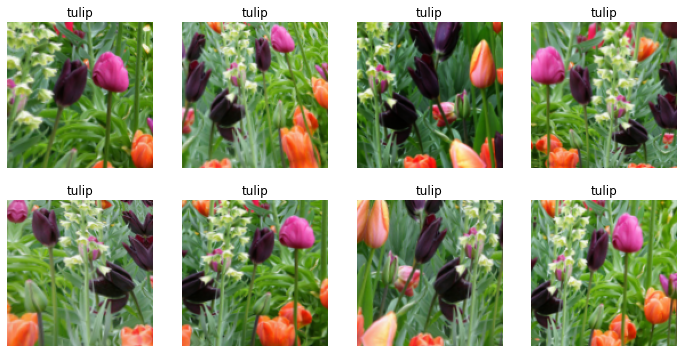

In [5]:
dls = db.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [6]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


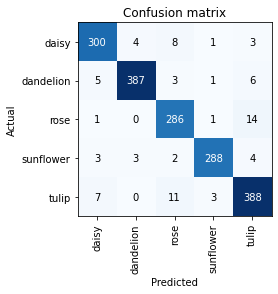

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

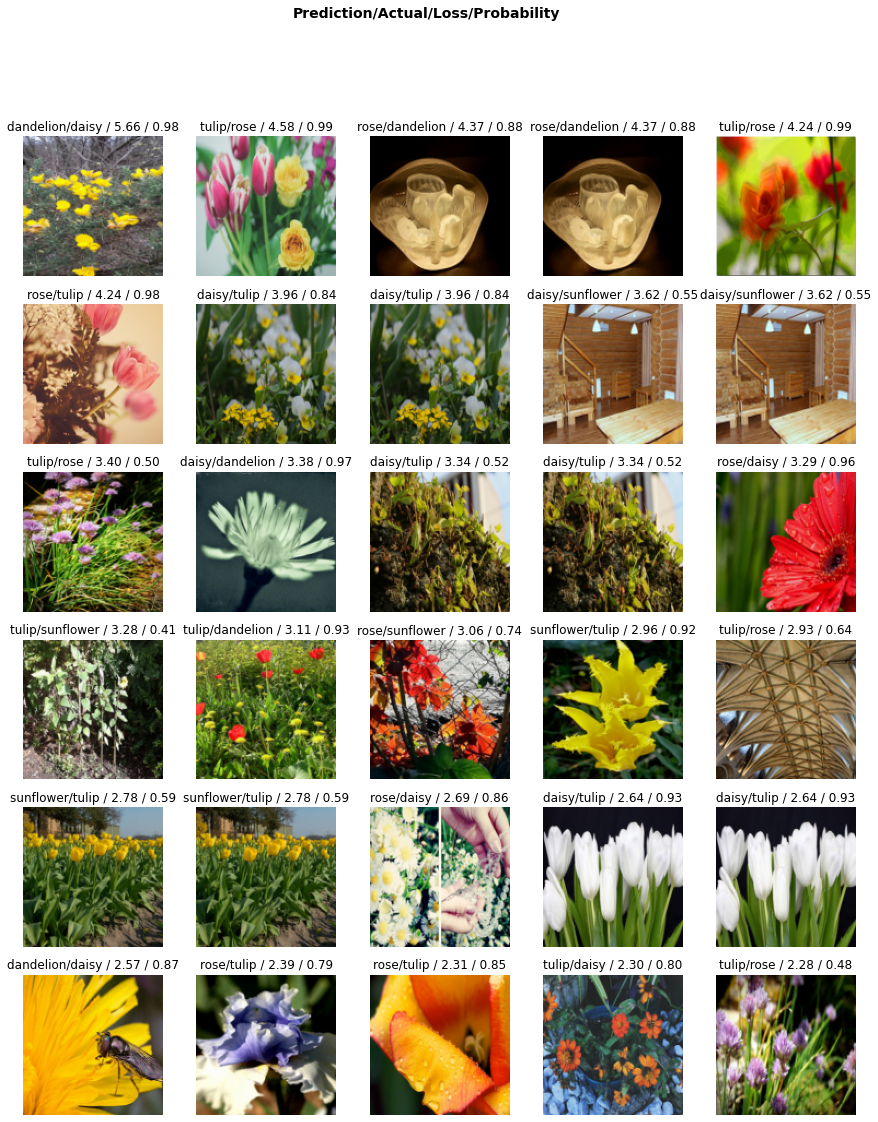

In [8]:
interp.plot_top_losses(30, nrows=6)

In [9]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [10]:
for idx in cleaner.delete() : cleaner.fns[idx].unlink()

In [11]:
learn.export()
saveDir = Path()
saveDir.ls(file_exts='.pkl')

(#2) [Path('export.pkl'),Path('identifyFlower.pkl')]

In [12]:
fileUpload = widgets.FileUpload()

saveDir = Path()
learn_inf = load_learner(saveDir/'identifyFlower.pkl')
learn_inf.dls.vocab

btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def onClickDisplay(change) :
  img = PILImage.create(fileUpload.data[-1])
  out_pl.clear_output()
  with out_pl:display(img.to_thumb(128,128))
  pred, predIdx, probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[predIdx]:.04f}'

btn_run.on_click(onClickDisplay)
VBox(
    [widgets.Label("Select Image File: "),
     fileUpload, btn_run, out_pl, lbl_pred]
)